# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from statistics import NormalDist
from scipy.stats import gaussian_kde
from scipy.stats import shapiro,jarque_bera
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import shapiro

# Data

Read the CSV file as nyc_property

In [2]:
nyc_property = pd.read_csv("nyc-rolling-sales.csv")

In [3]:
nyc_property.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


# Cleaning Data

Make a copy of the original data by defining it as df, so the original data is not corrupt

In [4]:
df = nyc_property.copy()

Remove irrelevant columns

In [5]:
df = df.drop(["Unnamed: 0"],axis=1)

In [6]:
df.columns = df.columns.str.replace(" ","_")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING_CLASS_CATEGORY         84548 non-null  object
 3   TAX_CLASS_AT_PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING_CLASS_AT_PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT_NUMBER                84548 non-null  object
 10  ZIP_CODE                        84548 non-null  int64 
 11  RESIDENTIAL_UNITS               84548 non-null  int64 
 12  COMMERCIAL_UNITS                84548 non-null

Convert to numeric variables

In [8]:
numeric = ["RESIDENTIAL_UNITS","COMMERCIAL_UNITS","TOTAL_UNITS", "LAND_SQUARE_FEET" , "GROSS_SQUARE_FEET","SALE_PRICE"]

for col in numeric: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

Convert to categorical variables

In [9]:
categorical = ['BOROUGH','NEIGHBORHOOD','BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT','ZIP_CODE', 'YEAR_BUILT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'TAX_CLASS_AT_TIME_OF_SALE']

for col in categorical: 
    df[col] = df[col].astype("category")

Convert to datetime variable:

In [10]:
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"])

Rename borough: 
- 1 = Manhattan 
- 2 = Bronx
- 3 = Brooklyn
- 4 = Queens 
- 5 = Staten Island

In [11]:
def renaming_borough(x):
    if x == 1:
        return "Manhattan"
    elif x == 2:
        return "Bronx"
    elif x == 3:
        return "Brooklyn"
    elif x == 4:
        return "Queens"
    else:
        return "Staten Island"
    
df["BOROUGH"] = df["BOROUGH"].apply(renaming_borough)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2016-12-14
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212.0,7803.0,1900,2,C7,NaN,2016-12-09
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17


Replace blank spaces with nan, then percentage the missing values

In [12]:
df.replace(' ',np.nan, inplace=True)
df.isna().sum() /len(df) *100

BOROUGH                             0.000000
NEIGHBORHOOD                        0.000000
BUILDING_CLASS_CATEGORY             0.000000
TAX_CLASS_AT_PRESENT                0.872877
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.872877
ADDRESS                             0.000000
APARTMENT_NUMBER                   77.466055
ZIP_CODE                            0.000000
RESIDENTIAL_UNITS                   0.000000
COMMERCIAL_UNITS                    0.000000
TOTAL_UNITS                         0.000000
LAND_SQUARE_FEET                   31.049818
GROSS_SQUARE_FEET                  32.658372
YEAR_BUILT                          0.000000
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                         17.222170
SALE_DATE                           0.000000
dtype: float64

Count the missing values

In [13]:
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                738
BLOCK                                 0
LOT                                   0
EASE-MENT                         84548
BUILDING_CLASS_AT_PRESENT           738
ADDRESS                               0
APARTMENT_NUMBER                  65496
ZIP_CODE                              0
RESIDENTIAL_UNITS                     0
COMMERCIAL_UNITS                      0
TOTAL_UNITS                           0
LAND_SQUARE_FEET                  26252
GROSS_SQUARE_FEET                 27612
YEAR_BUILT                            0
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                        14561
SALE_DATE                             0
dtype: int64

Drop irrelevant columns

In [14]:
df = df.drop(["EASE-MENT","APARTMENT_NUMBER", "BLOCK", "LOT", "ADDRESS"],axis=1)

Drop Nan values from TAX_CLASS_AT_PRESENT and BUILDING_CLASS_AT_PRESENT columns

In [15]:
df = df.dropna(subset=["TAX_CLASS_AT_PRESENT","BUILDING_CLASS_AT_PRESENT"])

Change Nan values with 0 in LAND_SQUARE_FEET, GROSS_SQUARE_FEET, and SALE_PRICE columns

In [16]:
for i in ["LAND_SQUARE_FEET","GROSS_SQUARE_FEET","SALE_PRICE"]:
    df[i] = df[i].fillna(0)

Take a sale price that is greater than 0

In [17]:
df = df[df["SALE_PRICE"] != 0]

In [18]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23
9,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D9,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28
84544,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21
84545,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B2,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05
84546,Staten Island,WOODROW,22 STORE BUILDINGS,4,K6,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21


Group all the sub-classess into 4 main classes

In [19]:
df["BUILDING_CLASS_AT_PRESENT"] = df["BUILDING_CLASS_AT_PRESENT"].str[0]

In [20]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23
9,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07


Take the years from SALE_DATE column and assign it to a new column called YEAR

In [21]:
df["YEAR"] = [i.year for i in df["SALE_DATE"]]

Check if there are any outliers using box plot

<AxesSubplot:xlabel='SALE_PRICE'>

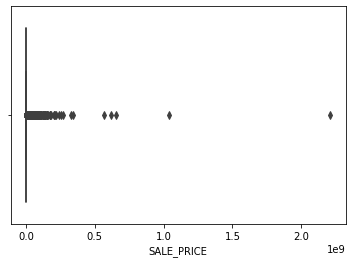

In [22]:
sns.boxplot(data=df,x="SALE_PRICE")

Remove outliers with IQR method

In [23]:
sale_price_q1 = df["SALE_PRICE"].describe().loc["25%"]
sale_price_q3 = df["SALE_PRICE"].describe().loc["75%"]
sale_price_iqr = sale_price_q3 - sale_price_q1

sale_price_lower_limit = sale_price_q1 - (1.5 * sale_price_iqr)
sale_price_upper_limit = sale_price_q3 + (1.5 * sale_price_iqr)

In [24]:
outliers_removed = df[(df["SALE_PRICE"] >= sale_price_lower_limit) & (df["SALE_PRICE"] <= sale_price_upper_limit)]
outliers_removed.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,YEAR
12,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,1.0,2016-09-06,2016
13,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,499000.0,2017-03-10,2017
14,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,10.0,2017-04-28,2017
15,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,529500.0,2017-06-09,2017
16,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,423000.0,2017-07-14,2017


<AxesSubplot:xlabel='SALE_PRICE'>

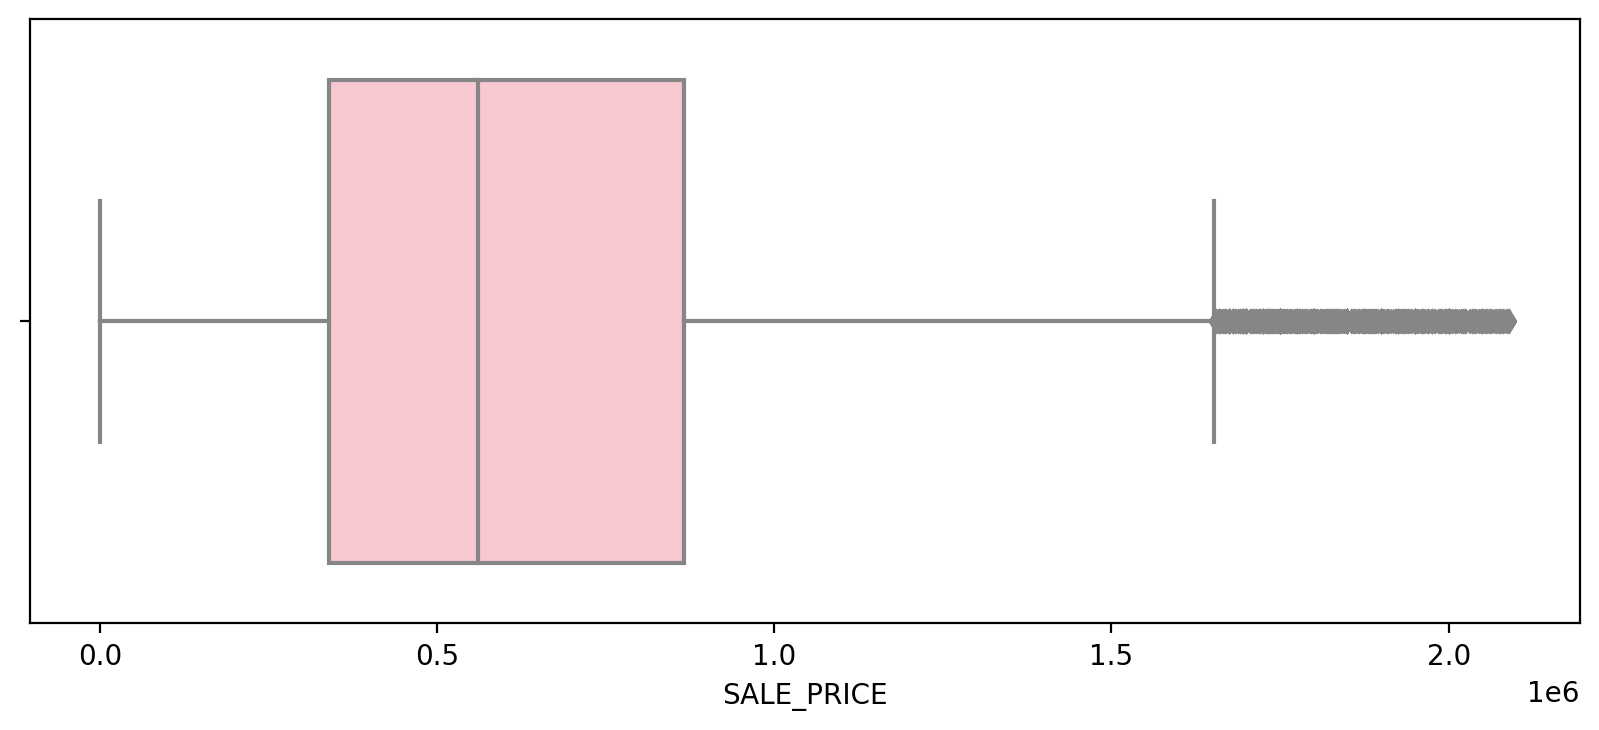

In [25]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=outliers_removed,x="SALE_PRICE", color="pink")

Because there's still a lot of outliers, repeat the step above as much as needed

In [26]:
n = 1
limit = 2

while n <= limit:
    sale_price_q1 = outliers_removed["SALE_PRICE"].describe().loc["25%"]
    sale_price_q3 = outliers_removed["SALE_PRICE"].describe().loc["75%"]
    sale_price_iqr = sale_price_q3 - sale_price_q1

    sale_price_lower_limit = sale_price_q1 - (1.5 * sale_price_iqr)
    sale_price_upper_limit = sale_price_q3 + (1.5 * sale_price_iqr)

    outliers_removed = outliers_removed[(outliers_removed["SALE_PRICE"] >= sale_price_lower_limit) & (outliers_removed["SALE_PRICE"] <= sale_price_upper_limit)]
    
    n += 1

<AxesSubplot:xlabel='SALE_PRICE'>

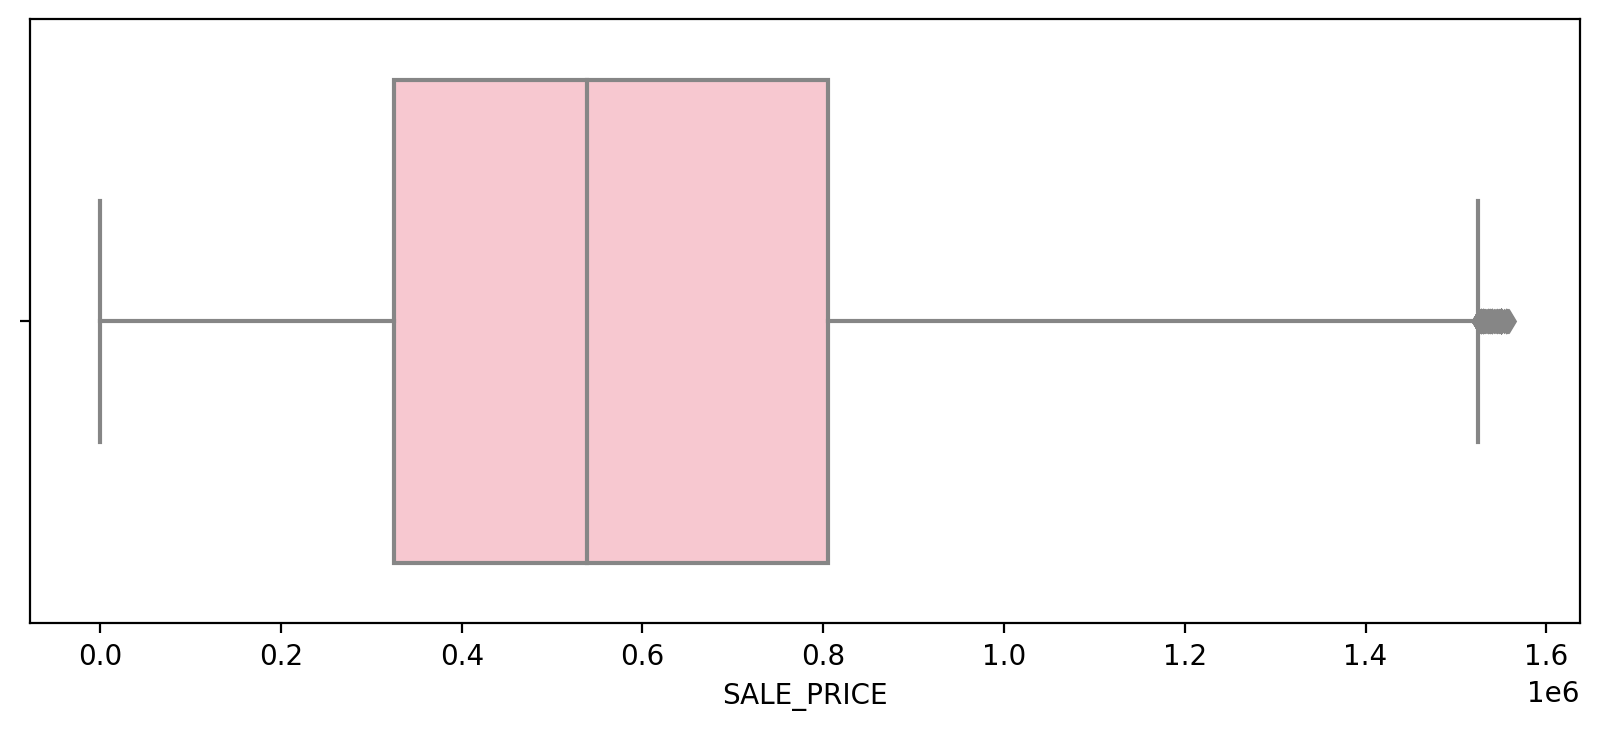

In [27]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=outliers_removed,x="SALE_PRICE", color="pink")

# Measures of Central Tendency

Find measures of central tendency:
- Mean 
- Median 
- Mode 
- Range 
- Variance
- Standard Deviation

In [28]:
mct = outliers_removed.groupby(["BOROUGH","BUILDING_CLASS_AT_PRESENT","YEAR"]).agg({"SALE_PRICE":[np.mean,
                                                                                    np.median,
                                                                                    statistics.mode,
                                                                                   np.ptp,
                                                                                   np.var,
                                                                                   np.std]})
mct = mct.reset_index()
mct.columns = mct.columns.droplevel(-1)
mct.columns = ['BOROUGH','BUILDING_CLASS_AT_PRESENT','YEAR','MEAN','MEDIAN','MODE','RANGE','VARIANCE','STANDARD_DEVIATION']
mct = mct.dropna()
mct

,BOROUGH,BUILDING_CLASS_AT_PRESENT,YEAR,MEAN,MEDIAN,MODE,RANGE,VARIANCE,STANDARD_DEVIATION
0,Manhattan,A,2016,1.001448e+06,1000000.0,1375000.0,1067758.0,1.909133e+11,436936.253145
1,Manhattan,A,2017,3.021925e+05,36255.0,10.0,1509990.0,2.854313e+11,534257.668432
2,Manhattan,B,2016,1.204500e+06,1310000.0,1310000.0,1050000.0,1.811638e+11,425633.351607
3,Manhattan,B,2017,7.530519e+05,850000.0,1386200.0,1549990.0,2.909754e+11,539421.326131
4,Manhattan,C,2016,5.476793e+05,473000.0,10.0,1524999.0,1.349916e+11,367412.020412
...,...,...,...,...,...,...,...,...,...
219,Staten Island,S,2017,3.959197e+05,402000.0,25000.0,900000.0,5.248968e+10,229106.270267
222,Staten Island,V,2016,3.577857e+05,280000.0,650000.0,1265000.0,1.079070e+11,328492.016367
223,Staten Island,V,2017,3.324611e+05,295292.0,350000.0,1199990.0,7.792322e+10,279147.313163
224,Staten Island,W,2016,1.000000e+00,1.0,1.0,0.0,0.000000e+00,0.000000


Visualize the mean of SALE_PRICE from the BUILDING_CLASS_AT_PRESENT category in every borough

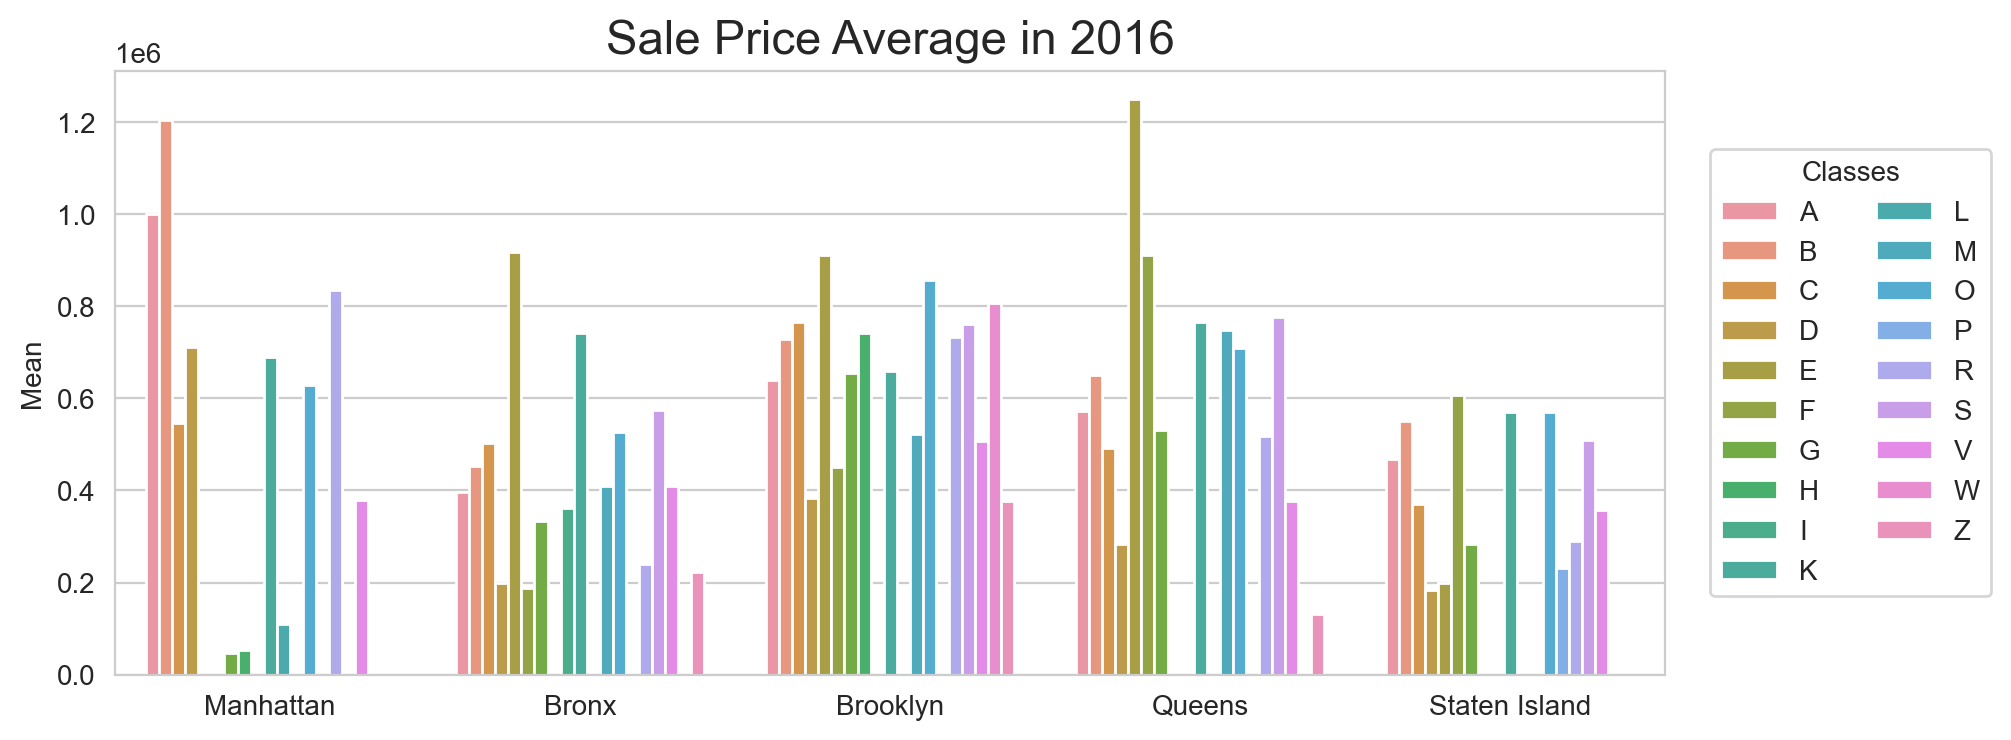

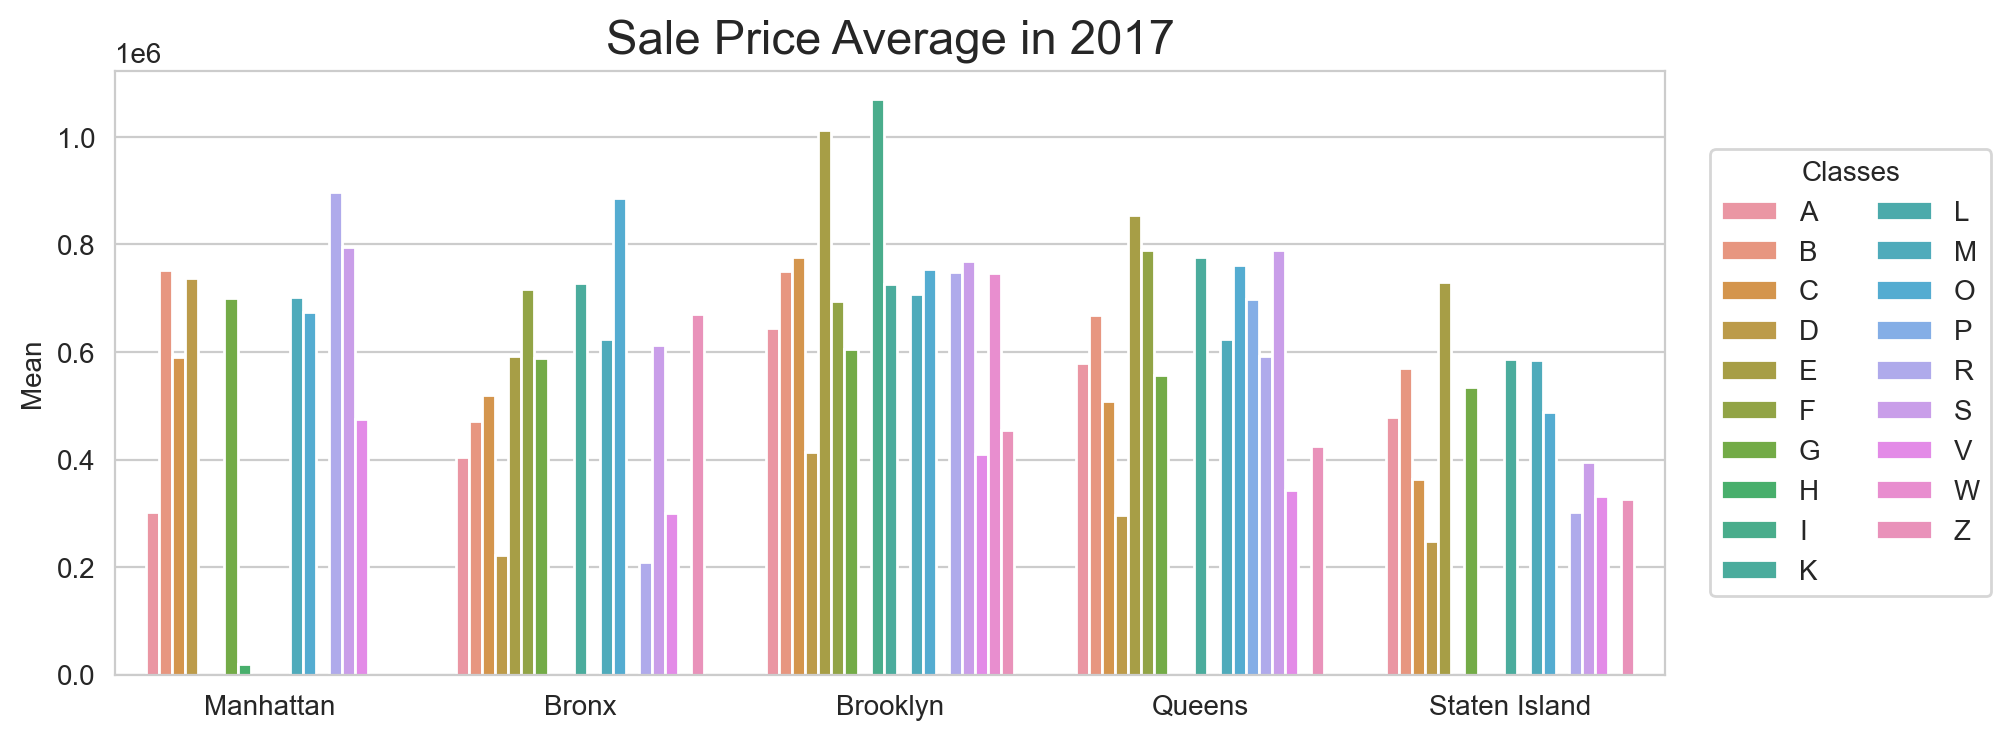

In [29]:
for i in mct["YEAR"].unique():

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(10,4),dpi=200)
        sns.barplot(data=mct[mct["YEAR"] == i],x="BOROUGH",y="MEAN",hue="BUILDING_CLASS_AT_PRESENT",hue_order=np.sort(mct["BUILDING_CLASS_AT_PRESENT"].unique()))
        plt.title(f"Sale Price Average in {i}", fontsize=17)
        plt.xlabel("")
        plt.ylabel("Mean")
        plt.legend(bbox_to_anchor=(1.02,0.5),loc="center left",title="Classes",ncol=2)
        plt.show()

# Confidence Intervals of Sample Mean

Sort the 5 highest BOROUGH based on SALE_PRICE mean from the BUILDING_CLASS_AT_PRESENT category in 2017

In [30]:
top_5 = mct[mct["YEAR"] == 2017].sort_values("MEAN",ascending=False).head(5)
top_5

,BOROUGH,BUILDING_CLASS_AT_PRESENT,YEAR,MEAN,MEDIAN,MODE,RANGE,VARIANCE,STANDARD_DEVIATION
109,Brooklyn,I,2017,1.070000e+06,1070000.0,975000.0,190000.0,1.805000e+10,134350.288425
101,Brooklyn,E,2017,1.012385e+06,1050000.0,1000000.0,1524000.0,1.886589e+11,434348.849517
33,Manhattan,R,2017,8.978346e+05,895041.0,10.0,1556799.0,1.274793e+11,357042.404200
73,Bronx,O,2017,8.868223e+05,941756.0,450000.0,960000.0,1.339007e+11,365924.399856
147,Queens,E,2017,8.539279e+05,707000.0,1250000.0,1297657.0,2.274052e+11,476870.214816


Slice the datasets based on BOROUGH, BUILDING_CLASS_AT_PRESENT, and YEAR that have the top 5 highest averages in SALE_PRICE. Then create an array of SALE_PRICE

In [31]:
temp = []
for i,j,k in zip(top_5["BOROUGH"],top_5["BUILDING_CLASS_AT_PRESENT"],top_5["YEAR"]):
    temp.append(outliers_removed[(outliers_removed["BOROUGH"] == i) & 
                                 (outliers_removed["BUILDING_CLASS_AT_PRESENT"] == j) &
                                 (outliers_removed["YEAR"] == k)])
    
top_5_sale_price = np.array(pd.concat(temp)["SALE_PRICE"])
top_5_sale_price

array([ 975000., 1165000.,  585000., ...,  610000., 1450000.,  660000.])

Take 30 random samples and count their means for 500 times. Then add those values into a list called sample_means

In [32]:
np.random.seed(807)
sample_means = []
n = 30 
for sample in range(0,500):
    sample_values = np.random.choice(a = top_5_sale_price, size = n)
    sample_mean = np.mean(sample_values)
    sample_means.append(sample_mean)

Visualize it and we can conclude that our data is normally distributed visually

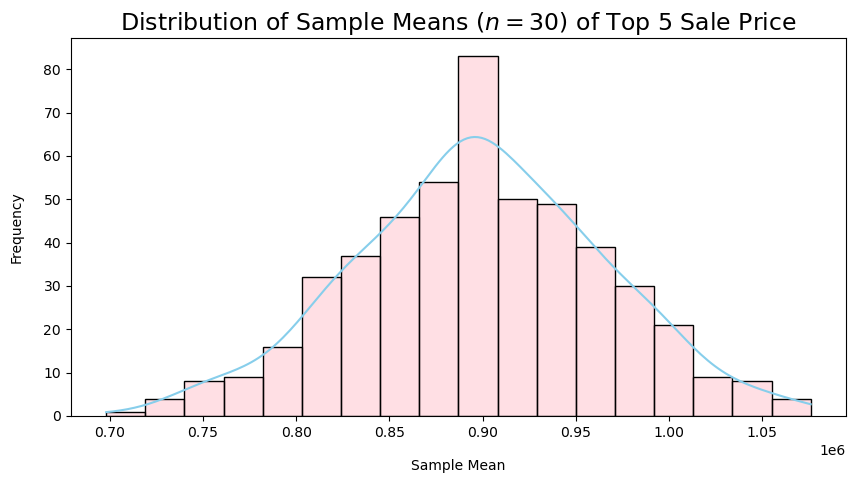

In [33]:
plt.figure(figsize=(10,5),dpi=100)
ax = sns.histplot(data=sample_means,kde=True,color="pink")
ax.lines[0].set_color("skyblue")
plt.title("Distribution of Sample Means ($n=30$) of Top 5 Sale Price", fontsize=17)
plt.xlabel("Sample Mean", labelpad=14)
plt.ylabel("Frequency", labelpad=14);
plt.show()

Calculate the value of z-score

In [34]:
conf = 0.95
z = NormalDist().inv_cdf((1 + conf) / 2)
z 

1.9599639845400536

Calculate the mean of sample_means

In [35]:
mean_of_sample_means = np.mean(sample_means)
mean_of_sample_means

898275.1747999999

Calculate the standard deviation of sample_means

In [36]:
std_of_sample_means = np.std(sample_means)
std_of_sample_means

66908.81983262519

Calculate the standard deviation of top_5_sale_price

In [37]:
pop_std_dev = top_5_sale_price.std()
pop_std_dev

357812.7052316646

Calculate the standard error of top_5_sale_price

In [38]:
se_pop = pop_std_dev/np.sqrt(n)
se_pop

65327.36333910982

Calculate the lower limit of top_5_sale_price

In [39]:
lower = mean_of_sample_means - z*se_pop
lower

770235.8954503824

Calculate the upper limit of top_5_sale_price

In [40]:
upper = mean_of_sample_means + z*se_pop
upper

1026314.4541496175

Visualize the confidence interval of the sample_means

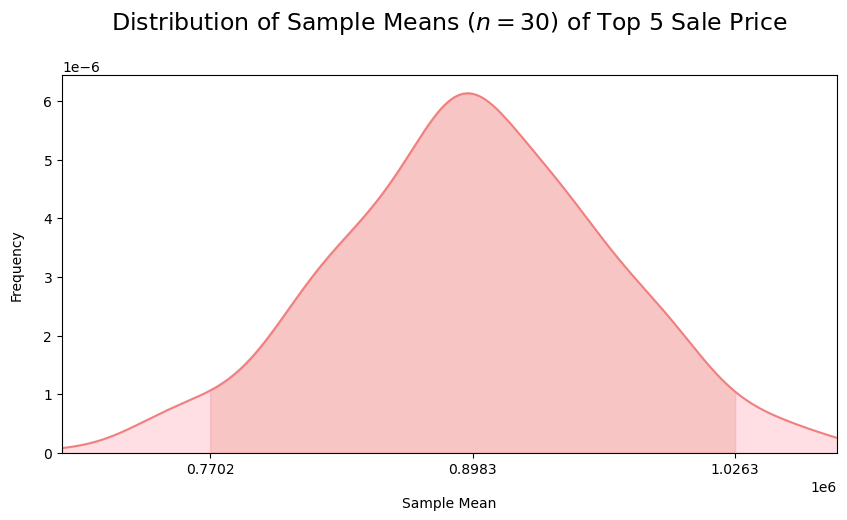

In [41]:
plt.figure(figsize=(10,5),dpi=100)
kde = gaussian_kde(sample_means)
pos = np.linspace(np.min(sample_means), np.max(sample_means), 10000)
plt.plot(pos, kde(pos), color="lightcoral")
shade = np.linspace(lower, upper, 300)

plt.fill_between(shade, kde(shade), alpha=0.45, color='lightcoral')
plt.xticks([lower,mean_of_sample_means,upper])
plt.xlim(xmin=np.min(sample_means),xmax=np.max(sample_means))
plt.ylim(ymin=0)

left = np.linspace(np.min(sample_means),lower,10000)
right = np.linspace(upper,np.max(sample_means),10000)
for i in [left,right]:
    plt.fill_between(i,kde(i),color="pink",alpha=0.5)
    
# plt.text(x=154, y=0.01, horizontalalignment='center', fontsize=3, s="95% of sample means fall within\nthis shaded area of plus or minus\n1.96 z-scores from the mean", bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.1"))
plt.title("Distribution of Sample Means ($n=30$) of Top 5 Sale Price", y=1.1, fontsize=17)
plt.xlabel("Sample Mean", labelpad=14)
plt.ylabel("Frequency", labelpad=14);
plt.show()

**Conclusion:** Based on the plot, it's determined that there's a $95\%$ chance that the mean of a sample of $N = 30$ will be within the pink shaded area. Thus, the probability that the mean of a sample with $N = 30$ will be outside the pink shaded area is $100\% - 95\%$ or $5\%$.

# Probability Distribution & Hypothesis Testing

### Hypothesis
- $H_{0}$: *top_1_sale_price* data is normally distributed
- $H_{1}$: *top_1_sale_price* data is not normally distributed

### Significance Level
$\alpha = 5\%$
### Test Statistics

Slice the datasets based on BOROUGH, BUILDING_CLASS_AT_PRESENT, and YEAR that have the top 1 highest averages in SALE_PRICE. Then create an array of SALE_PRICE

In [42]:
top_1 = mct[mct["YEAR"] == 2017].sort_values("MEAN",ascending=False).head(1)
top_1

,BOROUGH,BUILDING_CLASS_AT_PRESENT,YEAR,MEAN,MEDIAN,MODE,RANGE,VARIANCE,STANDARD_DEVIATION
109,Brooklyn,I,2017,1070000.0,1070000.0,975000.0,190000.0,1.805000e+10,134350.288425


In [43]:
top_1_sale_price = np.array(df[(df["BOROUGH"]==top_1["BOROUGH"].iloc[0]) & 
                               (df["BUILDING_CLASS_AT_PRESENT"]==top_1["BUILDING_CLASS_AT_PRESENT"].iloc[0]) &
                               (df["YEAR"]==top_1["YEAR"].iloc[0])]["SALE_PRICE"])
top_1_sale_price

array([ 4300000.,  7750184., 11750000.,  5757500., 27813450.,  8550000.,
         975000.,  1165000.])

Visualize with histogram to check the normality visually and check normality formally using Kolmorogov-Smirnov with Lilliefors significance correction and Shapiro-Wilk tests.

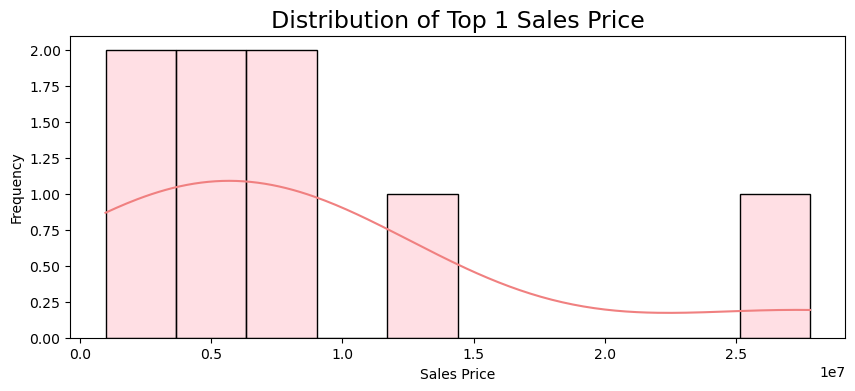

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.248039,0.171827,0.804168,0.031717


In [44]:
plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(data=top_1_sale_price,bins=10,kde=True, color="pink")
ax.lines[0].set_color("lightcoral")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.title("Distribution of Top 1 Sales Price", fontsize=17)

plt.show()

ks_stat,ks_pval = lilliefors(top_1_sale_price,dist="norm",pvalmethod="approx")
sw_stat,sw_pval = shapiro(top_1_sale_price)
pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pval],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pval]
},index=[""])

**Conclusion:** Based on the output above, it can be seen visually that the distribution has a substantial positive skewness, so it can be concluded that the data are not normally distributed. Then formally, the probability of Kolmogorov-Smirnov $= 0.172 > \alpha = 0.05$ and the probability of Shapiro-Wilk $= 0.03 < \alpha = 0.05$ so that it can be concluded that the data are not normally distributed. Therefore, the assumption of normality visually and formally has not been fulfilled, so a transformation is necessary. 

In [45]:
transform = np.log10(top_1_sale_price)
transform

array([6.63346846, 6.88931201, 7.07003787, 6.76023395, 7.44425486,
       6.93196611, 5.98900462, 6.06632593])

Then repeat with the same step, visualize with histogram to check the normality visually and check normality formally using Kolmorogov-Smirnov with Lilliefors significance correction and Shapiro-Wilk tests

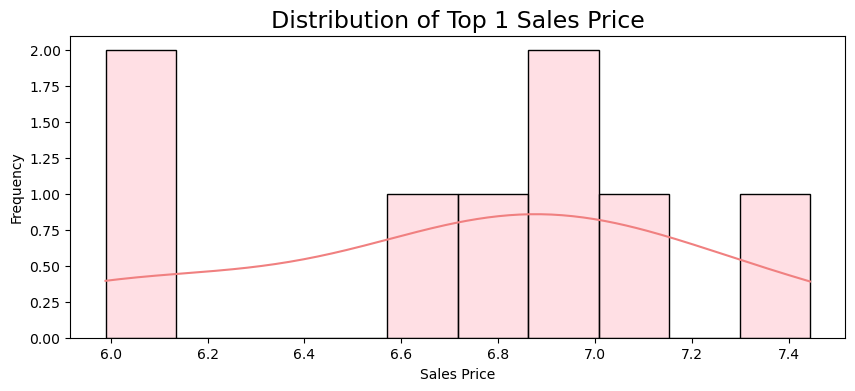

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.177676,0.645378,0.93502,0.562837


In [46]:
plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(data=transform,bins=10,kde=True, color="pink")
ax.lines[0].set_color("lightcoral")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.title("Distribution of Top 1 Sales Price", fontsize=17)

plt.show()

ks_stat,ks_pval = lilliefors(transform,dist="norm",pvalmethod="approx")
sw_stat,sw_pval = shapiro(transform)
pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pval],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pval]
},index=[""])

**Conclusion:** Based on the output above, it can be seen visually that the distribution is approximately symmetric, so it seems it's normally distributed. Then formally, the probability of Kolmogorov-Smirnov $= 0.65 > \alpha = 0.05$ and the p-values of Shapiro-Wilk $= 0.56 > \alpha = 0.05$ so that it can be concluded that the data are normally distributed. Therefore, the assumption of normality visually and formally fulfilled.